In [1]:
#!pip install PrettyTable

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
from IPython.display import display
from prettytable import PrettyTable

In [3]:
tickers = ["BHP.AX", "GOOGL", "AMZN", "WMT", "XOM", "BRK-A", "UNH", "UPS", "AMT", "AAPL", "NEE"]

data = yf.download(tickers, start="2019-01-02", end="2021-12-30")

returns = data["Adj Close"].pct_change()
returns = returns.fillna(returns.mean())
returns.reset_index(drop=True, inplace=True)  # Reset index

companies = {
    "BHP.AX": "BHP Group Limited",
    "GOOGL": "Alphabet.com, Inc.",
    "AMZN": "Amazon.com, Inc.",
    "WMT": "Walmart Inc.",
    "XOM": "Exxon Mobil Corporation",
    "BRK-A": "Berkshire Hathaway Inc.",
    "UNH": "UnitedHealth Group Incorporated",
    "UPS": "United Parcel Service, Inc.",
    "AMT": "American Tower Corporation",
    "AAPL": "Apple Inc.",
    "NEE": "NextEra Energy, Inc."
}

display(returns)
print(returns.isnull().sum())

[*********************100%***********************]  11 of 11 completed


,AAPL,AMT,AMZN,BHP.AX,BRK-A,GOOGL,NEE,UNH,UPS,WMT,XOM
0,0.002225,0.001036,0.001187,0.000741,0.000613,0.001494,0.001239,0.001221,0.001324,0.000712,0.000327
1,-0.099607,0.005997,-0.025241,0.000000,-0.056098,-0.027696,-0.002473,-0.027270,-0.028392,-0.005142,-0.015354
2,0.042689,0.003995,0.050064,-0.008907,0.019164,0.051294,0.018417,0.011695,0.034833,0.006246,0.036870
3,-0.002226,0.006191,0.034353,0.030258,0.009915,-0.001994,-0.001449,0.001920,-0.003376,0.011772,0.005200
4,0.019063,0.011300,0.016612,0.001163,-0.003724,0.008783,0.007314,0.013371,0.000103,0.006981,0.007271
...,...,...,...,...,...,...,...,...,...,...,...
769,0.003644,-0.004002,0.000184,-0.003141,0.000148,0.003425,-0.001101,0.002530,0.017991,-0.002217,0.000492
770,0.000000,0.000000,0.000000,0.001454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
771,0.022975,0.025185,-0.008178,0.000000,0.005523,0.006738,0.006836,0.008317,0.013761,0.009105,0.014258
772,-0.005767,0.009553,0.005844,0.000000,0.005502,-0.008245,0.006132,0.006887,-0.001999,0.014351,-0.003232


AAPL      0
AMT       0
AMZN      0
BHP.AX    0
BRK-A     0
GOOGL     0
NEE       0
UNH       0
UPS       0
WMT       0
XOM       0
dtype: int64


In [4]:
table = PrettyTable()
table.field_names = ["Ticker", "Company Name", "Market Cap", "Industry"]

In [5]:
for ticker in returns.columns:
    company_name = companies.get(ticker, "N/A")
    market_cap = yf.Ticker(ticker).info.get("marketCap", "N/A")
    industry = yf.Ticker(ticker).info.get("industry", "N/A")
    table.add_row([ticker, company_name, market_cap, industry])

# Display the table
display(table)

Ticker,Company Name,Market Cap,Industry
AAPL,Apple Inc.,2846265704448,Consumer Electronics
AMT,American Tower Corporation,87289856000,REIT—Specialty
AMZN,"Amazon.com, Inc.",1266441125888,Internet Retail
BHP.AX,BHP Group Limited,320641073152,Other Industrial Metals & Mining
BRK-A,Berkshire Hathaway Inc.,732130770944,Insurance—Diversified
GOOGL,"Alphabet.com, Inc.",833975353344,Internet Content & Information
NEE,"NextEra Energy, Inc.",149874720768,Utilities—Regulated Electric
UNH,UnitedHealth Group Incorporated,459576016896,Healthcare Plans
UPS,"United Parcel Service, Inc.",143093121024,Integrated Freight & Logistics
WMT,Walmart Inc.,412246867968,Discount Stores


In [6]:
from scipy.stats import skew, kurtosis
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Stock", "Max", "Min", "Mean", "Standard Deviation", "Cumulative Return", "Skewness", "Kurtosis"]

for ticker in returns.columns:
    stock_name = companies.get(ticker, "N/A")
    max_return = returns[ticker].max()
    min_return = returns[ticker].min()
    mean_return = returns[ticker].mean()
    std_return = returns[ticker].std()
    cumulative_return = (1 + returns[ticker]).cumprod().iloc[-1] - 1
    skewness = skew(returns[ticker].dropna())
    kurt = kurtosis(returns[ticker].dropna())
    
    table.add_row([stock_name[:20], f"{max_return:.4f}", f"{min_return:.4f}", f"{mean_return:.4f}", f"{std_return:.4f}",
                   f"{cumulative_return:.4f}", f"{skewness:.4f}", f"{kurt:.4f}"])

display(table)

Stock,Max,Min,Mean,Standard Deviation,Cumulative Return,Skewness,Kurtosis
Apple Inc.,0.1198,-0.1286,0.0022,0.0212,3.6907,-0.1580,6.3977
American Tower Corpo,0.1222,-0.1516,0.0010,0.0186,0.9511,0.1135,12.4330
"Amazon.com, Inc.",0.0793,-0.0792,0.0012,0.0183,1.2013,0.0826,2.6864
BHP Group Limited,0.1194,-0.1441,0.0007,0.0186,0.5501,-0.2436,8.4156
Berkshire Hathaway I,0.1129,-0.0855,0.0006,0.0141,0.4878,-0.1368,11.1625
"Alphabet.com, Inc.",0.0962,-0.1163,0.0015,0.0184,1.7852,-0.0717,6.2771
"NextEra Energy, Inc.",0.1369,-0.1342,0.0012,0.0177,1.3122,0.0445,13.8649
UnitedHealth Group I,0.1280,-0.1728,0.0012,0.0207,1.1791,-0.1155,13.1818
United Parcel Servic,0.1438,-0.0882,0.0013,0.0193,1.4151,0.8728,9.0257
Walmart Inc.,0.1171,-0.0907,0.0007,0.0138,0.6123,1.0971,15.4811


In [7]:
covariance_matrix = returns.cov()
display(covariance_matrix)

,AAPL,AMT,AMZN,BHP.AX,BRK-A,GOOGL,NEE,UNH,UPS,WMT,XOM
AAPL,0.000451,0.000185,0.000254,0.000078,0.000160,0.000262,0.000167,0.000217,0.000192,0.000124,0.000175
AMT,0.000185,0.000345,0.000124,0.000065,0.000120,0.000155,0.000218,0.000195,0.000136,0.000110,0.000122
AMZN,0.000254,0.000124,0.000334,0.000066,0.000081,0.000217,0.000102,0.000132,0.000127,0.000090,0.000084
BHP.AX,0.000078,0.000065,0.000066,0.000347,0.000071,0.000061,0.000061,0.000092,0.000057,0.000036,0.000127
BRK-A,0.000160,0.000120,0.000081,0.000071,0.000198,0.000137,0.000129,0.000176,0.000135,0.000073,0.000217
GOOGL,0.000262,0.000155,0.000217,0.000061,0.000137,0.000340,0.000146,0.000200,0.000148,0.000097,0.000184
NEE,0.000167,0.000218,0.000102,0.000061,0.000129,0.000146,0.000312,0.000179,0.000120,0.000110,0.000135
UNH,0.000217,0.000195,0.000132,0.000092,0.000176,0.000200,0.000179,0.000427,0.000165,0.000103,0.000209
UPS,0.000192,0.000136,0.000127,0.000057,0.000135,0.000148,0.000120,0.000165,0.000373,0.000100,0.000160
WMT,0.000124,0.000110,0.000090,0.000036,0.000073,0.000097,0.000110,0.000103,0.000100,0.000191,0.000069


In [8]:
correlation_matrix = returns.corr()
display(correlation_matrix)

,AAPL,AMT,AMZN,BHP.AX,BRK-A,GOOGL,NEE,UNH,UPS,WMT,XOM
AAPL,1.000000,0.468995,0.655123,0.196640,0.533886,0.669388,0.445861,0.494261,0.468640,0.423242,0.361883
AMT,0.468995,1.000000,0.366185,0.186976,0.457786,0.451451,0.664186,0.508896,0.380062,0.427514,0.288620
AMZN,0.655123,0.366185,1.000000,0.194220,0.314635,0.642655,0.317417,0.349586,0.358211,0.358052,0.200872
BHP.AX,0.196640,0.186976,0.194220,1.000000,0.268983,0.177446,0.186266,0.237846,0.158457,0.138802,0.299084
BRK-A,0.533886,0.457786,0.314635,0.268983,1.000000,0.526654,0.519046,0.604298,0.495470,0.375087,0.677843
GOOGL,0.669388,0.451451,0.642655,0.177446,0.526654,1.000000,0.450031,0.523976,0.415218,0.380906,0.437639
NEE,0.445861,0.664186,0.317417,0.186266,0.519046,0.450031,1.000000,0.489431,0.352855,0.451516,0.337111
UNH,0.494261,0.508896,0.349586,0.237846,0.604298,0.523976,0.489431,1.000000,0.413805,0.360608,0.445369
UPS,0.468640,0.380062,0.358211,0.158457,0.495470,0.415218,0.352855,0.413805,1.000000,0.376151,0.364204
WMT,0.423242,0.427514,0.358052,0.138802,0.375087,0.380906,0.451516,0.360608,0.376151,1.000000,0.219763


In [9]:
num_stocks = len(tickers)
initial_weights = np.ones(num_stocks) / num_stocks  #int equal weights
risk_free_rate = 0.025
max_weight = 0.2  #weight for each stock


window_size = 5  # Window size for EMA calculation
ema_multiplier = 2 / (window_size + 1)
ema_returns = returns.rolling(window=window_size).mean().iloc[window_size-1:]
cov_matrix_ema = ema_returns.cov()

def negative_sharpe_ratio(weights):
    portfolio_return = np.sum(weights * ema_returns.mean())
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_ema, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

def negative_portfolio_volatility(weights):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_ema, weights)))
    return -portfolio_volatility.item()

constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weight sum const
    {'type': 'ineq', 'fun': lambda x: max_weight - x},  # weight upper bound const
    {'type': 'ineq', 'fun': lambda x: x}  # non negativity const
]
bounds = tuple((0, None) for _ in range(num_stocks))

# Calculate MSRP
result_msrp = minimize(
    negative_sharpe_ratio,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
optimal_weights_msrp = result_msrp.x
optimal_weights_msrp[optimal_weights_msrp < 1e-6] = 0  #setting small number
# Calculate GMVP
result_gmvp = minimize(
    negative_portfolio_volatility,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
optimal_weights_gmvp = result_gmvp.x
optimal_weights_gmvp[optimal_weights_gmvp < 1e-6] = 0  #setting small number


portfolio_msrp = {companies[tickers[i]]: optimal_weights_msrp[i] for i in range(num_stocks) if optimal_weights_msrp[i] > 0}
portfolio_gmvp = {companies[tickers[i]]: optimal_weights_gmvp[i] for i in range(num_stocks) if optimal_weights_gmvp[i] > 0}

print("Optimal Portfolio Composition (MSRP):")
display(portfolio_msrp)

print("Optimal Portfolio Composition (GMVP):")
display(portfolio_gmvp)


Optimal Portfolio Composition (MSRP):


{'BHP Group Limited': 0.20000000000330392,
 'Berkshire Hathaway Inc.': 0.20000000000389337,
 'United Parcel Service, Inc.': 0.20000000000346962,
 'American Tower Corporation': 0.20000000000121157,
 'NextEra Energy, Inc.': 0.20000000000364143}

Optimal Portfolio Composition (GMVP):


{'BHP Group Limited': 0.2000000000000003,
 'Amazon.com, Inc.': 0.009772016975257848,
 'Walmart Inc.': 0.02295194650847079,
 'Exxon Mobil Corporation': 0.022231356120179954,
 'Berkshire Hathaway Inc.': 0.2000000000000003,
 'UnitedHealth Group Incorporated': 0.0704533903782596,
 'United Parcel Service, Inc.': 0.20000000000000026,
 'American Tower Corporation': 0.07459129001783182,
 'NextEra Energy, Inc.': 0.1999999999999999}

In [10]:
benchmark_ticker = "^GSPC"  # S&P500 index

# Download historical data from Yahoo Finance
start_date = "2022-01-03"
end_date = "2022-09-02"
data = yf.download(tickers + [benchmark_ticker], start=start_date, end=end_date)["Adj Close"]

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod() - 1

# Calculate annual volatility
annual_volatility = returns.std() * np.sqrt(252)  # Assuming 252 trading days in a year

# Calculate relative returns against the benchmark
relative_returns = cumulative_returns.sub(cumulative_returns[benchmark_ticker], axis=0)

# Calculate Sharpe ratio
risk_free_rate = 0.025  # Assuming risk-free rate of return is zero
sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std()

# Calculate maximum drawdown
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / (rolling_max + 1e-8)

[*********************100%***********************]  12 of 12 completed


In [11]:
sp500_returns = (returns["^GSPC"])
cumulative_returns_sp500 = (1 + sp500_returns).cumprod() - 1

msrp_weights = result_msrp.x  # Optimal composition for MSRP
msrp_returns = (returns[tickers] * msrp_weights).sum(axis=1)
msrp_returns.name = "MSRP"
msrp_cumulative_return = (1 + msrp_returns).cumprod() - 1
msrp_annual_volatility = msrp_returns.std() * np.sqrt(252)
msrp_relative_return = msrp_cumulative_return - cumulative_returns[benchmark_ticker]
msrp_sharpe_ratio = (msrp_returns.mean() - risk_free_rate) / msrp_returns.std()
msrp_max_drawdown = drawdown[tickers].min()

gmvp_weights = result_gmvp.x  # Optimal composition for GMVP
gmvp_returns = (returns[tickers] * gmvp_weights).sum(axis=1)
gmvp_returns.name = "GMVP"
gmvp_cumulative_return = (1 + gmvp_returns).cumprod() - 1
gmvp_annual_volatility = gmvp_returns.std() * np.sqrt(252)
gmvp_relative_return = gmvp_cumulative_return - cumulative_returns[benchmark_ticker]
gmvp_sharpe_ratio = (gmvp_returns.mean() - risk_free_rate) / gmvp_returns.std()
gmvp_max_drawdown = drawdown[tickers].min()

equal_weights = np.ones(len(tickers)) / len(tickers)
equal_returns = (returns[tickers] * equal_weights).sum(axis=1)
equal_returns.name = "1/N"
equal_cumulative_return = (1 + equal_returns).cumprod() - 1
equal_annual_volatility = equal_returns.std() * np.sqrt(252)
equal_relative_return = equal_cumulative_return - cumulative_returns[benchmark_ticker]
equal_sharpe_ratio = (equal_returns.mean() - risk_free_rate) / equal_returns.std()
equal_max_drawdown = drawdown[tickers].min()

In [12]:
performance_table = pd.DataFrame({
    "Investment Strategy": ["MSRP", "GMVP", "1/N", "S&P500 (Benchmark)"],
    "Simple Return (%)": [msrp_returns.mean(), gmvp_returns.mean(), equal_returns.mean(), returns[benchmark_ticker].mean()],
    "Cumulative Return (%)": [msrp_cumulative_return[-1], gmvp_cumulative_return[-1], equal_cumulative_return[-1], cumulative_returns[benchmark_ticker][-1]],
    "Annual Volatility (%)": [msrp_annual_volatility, gmvp_annual_volatility, equal_annual_volatility, annual_volatility[benchmark_ticker]],
    "Relative Return (%)": [msrp_relative_return[-1], gmvp_relative_return[-1], equal_relative_return[-1], np.nan],
    "Sharpe Ratio": [msrp_sharpe_ratio, gmvp_sharpe_ratio, equal_sharpe_ratio, np.nan],
    "Maximum Drawdown (%)": [msrp_max_drawdown, gmvp_max_drawdown, equal_max_drawdown, drawdown[benchmark_ticker].min()]
})

display(performance_table)


,Investment Strategy,Simple Return (%),Cumulative Return (%),Annual Volatility (%),Relative Return (%),Sharpe Ratio,Maximum Drawdown (%)
0,MSRP,-0.000174,-0.039891,0.180557,0.132569,-2.213261,BHP.AX -1.352278 GOOGL -11.937246 AMZN ...
1,GMVP,-0.000053,-0.019199,0.174134,0.153260,-2.283936,BHP.AX -1.352278 GOOGL -11.937246 AMZN ...
2,1/N,-0.000073,-0.025849,0.201220,0.146610,-1.978053,BHP.AX -1.352278 GOOGL -11.937246 AMZN ...
3,S&P500 (Benchmark),-0.000997,-0.172459,0.235545,NaN,NaN,-0.0


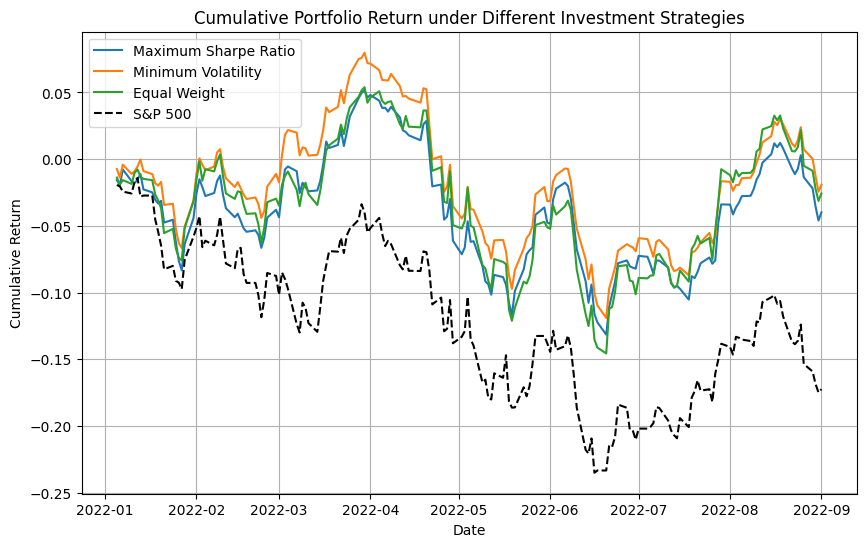

In [13]:
import matplotlib.pyplot as plt

# Calculate the cumulative portfolio returns
#msrp_cumulative_return = (1 + msrp_returns).cumprod() - 1
#cumulative_returns_msrp = (1 + (returns * optimal_weights_msrp)).cumprod().sum(axis=1) - 1
#cumulative_returns_gmvp = (1 + (returns * optimal_weights_gmvp)).cumprod().sum(axis=1) - 1
cumulative_returns_equal = returns.mean(axis=1).cumsum()

# Assuming you have the S&P 500 returns data in a variable called sp500_returns


# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(msrp_cumulative_return, label="Maximum Sharpe Ratio")
plt.plot(gmvp_cumulative_return, label="Minimum Volatility")
plt.plot(cumulative_returns_equal, label="Equal Weight")
plt.plot(cumulative_returns_sp500, label="S&P 500", linestyle='--', color="black")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Portfolio Return under Different Investment Strategies")
plt.legend()
plt.grid(True)
plt.show()

## This project on the application of **Maximum Sharpe Ratio and Minimum Variance Portfolio Optimization for Industries** has provided valuable insights into portfolio management strategies. However, there were certain limitations and areas for improvement that should be acknowledged.

**Firstly, the project encountered difficulties due to the lack of clarity regarding the depth for each calculation.** This ambiguity hindered the full replication of the research and may have affected the accuracy of the results. Additionally, minor errors, such as **mislabeling Table 3** as a covariance table instead of a correlation table, were present. These mistakes, although relatively small, should be addressed to ensure the integrity and reliability of the findings.

One notable limitation of the study was the **absence of detailed explanations accompanying the calculations and methodology.** While the overall concept was clear, a more comprehensive and step-by-step explanation would have facilitated a better understanding of the research process and outcomes. This aspect should be emphasized in future iterations of the project to enhance the accessibility and educational value of the work.

Furthermore, **the project was conducted within specific portfolio limitations, without further explanation**, such as a **maximum weight allocation of 0.2** and the requirement to select one stock from different industries. While these constraints may have been necessary for the purposes of the study, they might limit the project's ability to fully capture real-world portfolio investment strategies and the decisions made by investors. Exploring a broader range of weight allocations and considering multiple stocks from the same industry could offer a more realistic representation of portfolio management practices.

**Finally,** to further enhance the robustness of the findings, conducting backtesting using a variety of estimation models would be beneficial. This approach would provide a more comprehensive assessment of the portfolio optimization techniques and their performance across different market conditions and data sets. By testing the strategies against alternative models, the project's results can be validated and their applicability in different scenarios can be better understood.

**In conclusion,** while the project made progress in exploring the application of Maximum Sharpe Ratio and Minimum Variance Portfolio Optimization for Industries, it is important to acknowledge the limitations and areas for improvement. Addressing the issues related to calculation depth, ensuring accurate labeling of tables, providing detailed explanations, expanding portfolio limitations, and conducting extensive backtesting would contribute to a more comprehensive and insightful study of portfolio management strategies.

In [14]:
benchmark_ticker_2 = "^GSPC"  # S&P500 index

# Download historical data from Yahoo Finance
start_date_2 = "2019-01-03"
end_date_2 = "2020-01-02"
data_2 = yf.download(tickers + [benchmark_ticker_2], start=start_date_2, end=end_date_2)["Adj Close"]

# Calculate daily returns
returns_2 = data_2.pct_change().dropna()

# Calculate annual returns
annual_returns_2 = (1 + returns_2).cumprod() - 1

# Calculate annual volatility
annual_volatility_2 = returns_2.std() * np.sqrt(252)  # Assuming 252 trading days in a year

# Calculate relative returns against the benchmark
relative_returns_2 = annual_returns_2.sub(annual_returns_2[benchmark_ticker_2], axis=0)

# Calculate Sharpe ratio
risk_free_rate_2 = 0.025  # Assuming risk-free rate of return is zero
sharpe_ratio_2 = (returns_2.mean() - risk_free_rate_2) / returns_2.std()

# Calculate maximum drawdown
rolling_max_2 = annual_returns_2.cummax()
drawdown_2 = (annual_returns_2 - rolling_max_2) / (rolling_max_2 + 1e-8)

[*********************100%***********************]  12 of 12 completed


In [15]:
sp500_returns_2 = (returns_2["^GSPC"])
annual_returns_sp500_2 = (1 + sp500_returns_2).cumprod() - 1

msrp_weights_2 = result_msrp.x  # Optimal composition for MSRP
msrp_returns_2 = (returns_2[tickers] * msrp_weights_2).sum(axis=1)
msrp_returns_2.name = "MSRP"
msrp_annual_return_2 = (1 + msrp_returns_2).cumprod() - 1
msrp_annual_volatility_2 = msrp_returns_2.std() * np.sqrt(252)
msrp_relative_return_2 = msrp_annual_return_2 - annual_returns_2[benchmark_ticker_2]
msrp_sharpe_ratio_2 = (msrp_returns_2.mean() - risk_free_rate_2) / msrp_returns_2.std()
msrp_max_drawdown_2 = drawdown_2[tickers].min()

gmvp_weights_2 = result_gmvp.x  # Optimal composition for GMVP
gmvp_returns_2 = (returns_2[tickers] * gmvp_weights_2).sum(axis=1)
gmvp_returns_2.name = "GMVP"
gmvp_annual_return_2 = (1 + gmvp_returns_2).cumprod() - 1
gmvp_annual_volatility_2 = gmvp_returns_2.std() * np.sqrt(252)
gmvp_relative_return_2 = gmvp_annual_return_2 - annual_returns_2[benchmark_ticker_2]
gmvp_sharpe_ratio_2 = (gmvp_returns_2.mean() - risk_free_rate_2) / gmvp_returns_2.std()
gmvp_max_drawdown_2 = drawdown_2[tickers].min()

equal_weights_2 = np.ones(len(tickers)) / len(tickers)
equal_returns_2 = (returns_2[tickers] * equal_weights_2).sum(axis=1)
equal_returns_2.name = "1/N"
equal_annual_return_2 = (1 + equal_returns_2).cumprod() - 1
equal_annual_volatility_2 = equal_returns_2.std() * np.sqrt(252)
equal_relative_return_2 = equal_annual_return_2 - annual_returns_2[benchmark_ticker_2]
equal_sharpe_ratio_2 = (equal_returns_2.mean() - risk_free_rate_2) / equal_returns_2.std()
equal_max_drawdown_2 = drawdown_2[tickers].min()

In [16]:
performance_table_2 = pd.DataFrame({
    "Investment Strategy": ["MSRP", "GMVP", "1/N", "S&P500 (Benchmark)"],
    "Simple Return (%)": [msrp_returns_2.mean(), gmvp_returns_2.mean(), equal_returns_2.mean(), returns_2[benchmark_ticker_2].mean()],
    "Cumulative Return (%)": [msrp_annual_return_2[-1], gmvp_annual_return_2[-1], equal_annual_return_2[-1], annual_returns_2[benchmark_ticker_2][-1]],
    "Annual Volatility (%)": [msrp_annual_volatility_2, gmvp_annual_volatility_2, equal_annual_volatility_2, annual_volatility_2[benchmark_ticker_2]],
    "Relative Return (%)": [msrp_relative_return_2[-1], gmvp_relative_return_2[-1], equal_relative_return_2[-1], np.nan],
    "Sharpe Ratio": [msrp_sharpe_ratio_2, gmvp_sharpe_ratio_2, equal_sharpe_ratio_2, np.nan],
    "Maximum Drawdown (%)": [msrp_max_drawdown_2, gmvp_max_drawdown_2, equal_max_drawdown_2, drawdown_2[benchmark_ticker_2].min()]
})

display(performance_table_2)

,Investment Strategy,Simple Return (%),Cumulative Return (%),Annual Volatility (%),Relative Return (%),Sharpe Ratio,Maximum Drawdown (%)
0,MSRP,0.001185,0.348955,0.086978,0.029133,-4.346534,BHP.AX -0.706674 GOOGL -0.950984 AMZN ...
1,GMVP,0.001097,0.318709,0.088823,-0.001113,-4.271988,BHP.AX -0.706674 GOOGL -0.950984 AMZN ...
2,1/N,0.001220,0.358967,0.104029,0.039144,-3.628724,BHP.AX -0.706674 GOOGL -0.950984 AMZN ...
3,S&P500 (Benchmark),0.001114,0.319822,0.121073,NaN,NaN,-0.404426


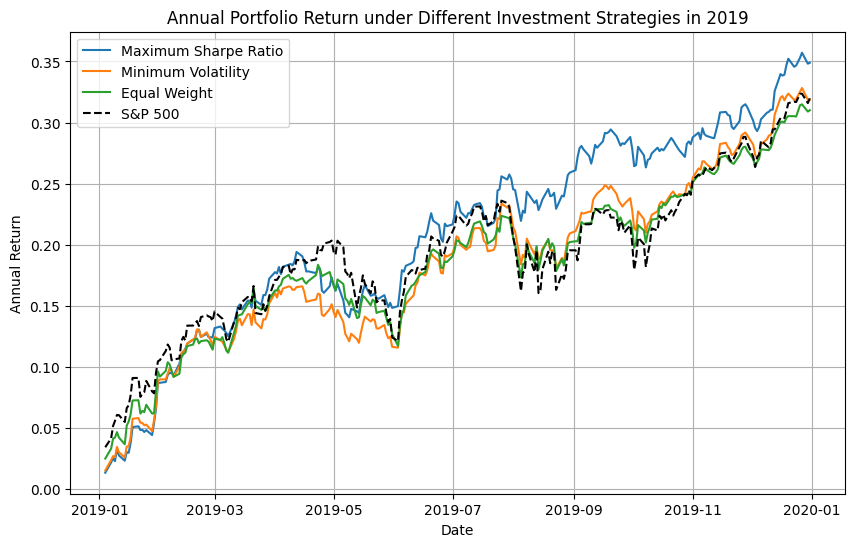

In [17]:
import matplotlib.pyplot as plt

# Calculate the cumulative portfolio returns
#msrp_cumulative_return = (1 + msrp_returns).cumprod() - 1
#cumulative_returns_msrp = (1 + (returns * optimal_weights_msrp)).cumprod().sum(axis=1) - 1
#cumulative_returns_gmvp = (1 + (returns * optimal_weights_gmvp)).cumprod().sum(axis=1) - 1
cumulative_returns_equal_2 = returns_2.mean(axis=1).cumsum()

# Assuming you have the S&P 500 returns data in a variable called sp500_returns


# Plot the annual returns
plt.figure(figsize=(10, 6))
plt.plot(msrp_annual_return_2, label="Maximum Sharpe Ratio")
plt.plot(gmvp_annual_return_2, label="Minimum Volatility")
plt.plot(cumulative_returns_equal_2, label="Equal Weight")
plt.plot(annual_returns_sp500_2, label="S&P 500", linestyle='--', color="black")
plt.xlabel("Date")
plt.ylabel("Annual Return")
plt.title("Annual Portfolio Return under Different Investment Strategies in 2019")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
benchmark_ticker_3 = "^GSPC"  # S&P500 index

# Download historical data from Yahoo Finance
start_date_3 = "2020-01-01"
end_date_3 = "2021-01-31"
data_3 = yf.download(tickers + [benchmark_ticker_3], start=start_date_3, end=end_date_3)["Adj Close"]

# Calculate daily returns
returns_3 = data_3.pct_change().dropna()

# Calculate cumulative returns
annual_returns_3 = (1 + returns_3).cumprod() - 1

# Calculate annual volatility
annual_volatility_3 = returns_3.std() * np.sqrt(252)  # Assuming 252 trading days in a year

# Calculate relative returns against the benchmark
relative_returns_3 = annual_returns_3.sub(annual_returns_3[benchmark_ticker_3], axis=0)

# Calculate Sharpe ratio
risk_free_rate_3 = 0.025  # Assuming risk-free rate of return is zero
sharpe_ratio_3 = (returns_3.mean() - risk_free_rate_3) / returns_3.std()

# Calculate maximum drawdown
rolling_max_3 = annual_returns_3.cummax()
drawdown_3 = (annual_returns_3 - rolling_max_3) / (rolling_max_3 + 1e-8)


[*********************100%***********************]  12 of 12 completed


In [19]:
sp500_returns_3 = (returns_3["^GSPC"])
annual_returns_sp500_3 = (1 + sp500_returns_3).cumprod() - 1

msrp_weights_3 = result_msrp.x  # Optimal composition for MSRP
msrp_returns_3 = (returns_3[tickers] * msrp_weights_3).sum(axis=1)
msrp_returns_3.name = "MSRP"
msrp_annual_return_3 = (1 + msrp_returns_3).cumprod() - 1
msrp_annual_volatility_3 = msrp_returns_3.std() * np.sqrt(365)
msrp_relative_return_3 = msrp_annual_return_3 - annual_returns_3[benchmark_ticker_3]
msrp_sharpe_ratio_3 = (msrp_returns_3.mean() - risk_free_rate_3) / msrp_returns_3.std()
msrp_max_drawdown_3 = drawdown_3[tickers].min()

gmvp_weights_3 = result_gmvp.x  # Optimal composition for GMVP
gmvp_returns_3 = (returns_3[tickers] * gmvp_weights_3).sum(axis=1)
gmvp_returns_3.name = "GMVP"
gmvp_annual_return_3 = (1 + gmvp_returns_3).cumprod() - 1
gmvp_annual_volatility_3 = gmvp_returns_3.std() * np.sqrt(365)
gmvp_relative_return_3 = gmvp_annual_return_3 - annual_returns_3[benchmark_ticker_3]
gmvp_sharpe_ratio_3 = (gmvp_returns_3.mean() - risk_free_rate_3) / gmvp_returns_3.std()
gmvp_max_drawdown_3 = drawdown_3[tickers].min()

equal_weights_3 = np.ones(len(tickers)) / len(tickers)
equal_returns_3 = (returns_3[tickers] * equal_weights_3).sum(axis=1)
equal_returns_3.name = "1/N"
equal_annual_return_3 = (1 + equal_returns_3).cumprod() - 1
equal_annual_volatility_3 = equal_returns_3.std() * np.sqrt(365)
equal_relative_return_3 = equal_annual_return_3 - annual_returns_3[benchmark_ticker_3]
equal_sharpe_ratio_3 = (equal_returns_3.mean() - risk_free_rate_3) / equal_returns_3.std()
equal_max_drawdown_3 = drawdown_3[tickers].min()

In [20]:
performance_table_3 = pd.DataFrame({
    "Investment Strategy": ["MSRP", "GMVP", "1/N", "S&P500 (Benchmark)"],
    "Simple Return (%)": [msrp_returns_3.mean(), gmvp_returns_3.mean(), equal_returns_3.mean(), returns_3[benchmark_ticker_3].mean()],
    "annual Return (%)": [msrp_annual_return_3[-1], gmvp_annual_return_3[-1], equal_annual_return_3[-1], annual_returns_3[benchmark_ticker_3][-1]],
    "Annual Volatility (%)": [msrp_annual_volatility_3, gmvp_annual_volatility_3, equal_annual_volatility_3, annual_volatility_3[benchmark_ticker_3]],
    "Relative Return (%)": [msrp_relative_return_3[-1], gmvp_relative_return_3[-1], equal_relative_return_3[-1], np.nan],
    "Sharpe Ratio": [msrp_sharpe_ratio_3, gmvp_sharpe_ratio_3, equal_sharpe_ratio_3, np.nan],
    "Maximum Drawdown (%)": [msrp_max_drawdown_3, gmvp_max_drawdown_3, equal_max_drawdown_3, drawdown_3[benchmark_ticker_3].min()]
})

display(performance_table_3)

,Investment Strategy,Simple Return (%),annual Return (%),Annual Volatility (%),Relative Return (%),Sharpe Ratio,Maximum Drawdown (%)
0,MSRP,0.000888,0.219775,0.355857,0.079686,-1.294524,BHP.AX -6.669509 GOOGL -3.013892 AMZN ...
1,GMVP,0.000926,0.234867,0.349486,0.094778,-1.316033,BHP.AX -6.669509 GOOGL -3.013892 AMZN ...
2,1/N,0.001031,0.269116,0.355945,0.129027,-1.286493,BHP.AX -6.669509 GOOGL -3.013892 AMZN ...
3,S&P500 (Benchmark),0.000691,0.140089,0.331232,NaN,NaN,-8.953636


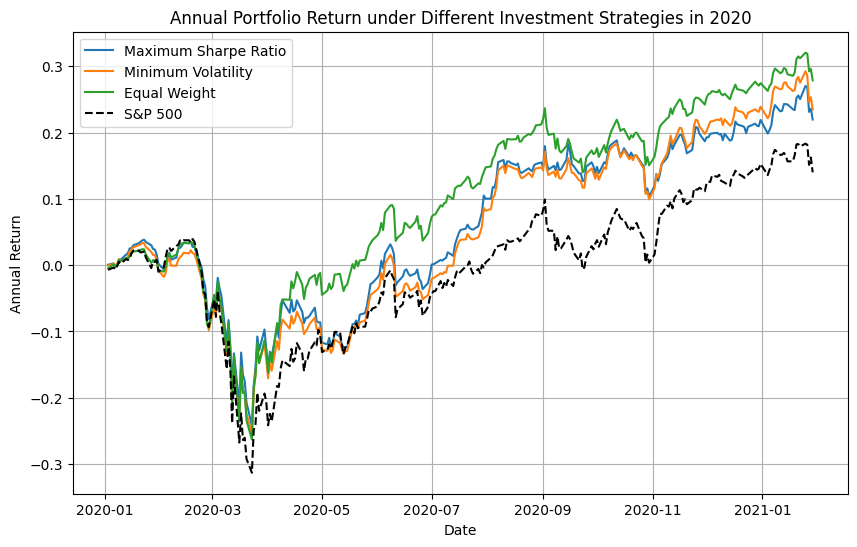

In [21]:
import matplotlib.pyplot as plt

# Calculate the cumulative portfolio returns
#msrp_cumulative_return = (1 + msrp_returns).cumprod() - 1
#cumulative_returns_msrp = (1 + (returns * optimal_weights_msrp)).cumprod().sum(axis=1) - 1
#cumulative_returns_gmvp = (1 + (returns * optimal_weights_gmvp)).cumprod().sum(axis=1) - 1
annual_returns_equal_3 = returns_3.mean(axis=1).cumsum()

# Assuming you have the S&P 500 returns data in a variable called sp500_returns


# Plot the annual returns
plt.figure(figsize=(10, 6))
plt.plot(msrp_annual_return_3, label="Maximum Sharpe Ratio")
plt.plot(gmvp_annual_return_3, label="Minimum Volatility")
plt.plot(annual_returns_equal_3, label="Equal Weight")
plt.plot(annual_returns_sp500_3, label="S&P 500", linestyle='--', color="black")
plt.xlabel("Date")
plt.ylabel("Annual Return")
plt.title("Annual Portfolio Return under Different Investment Strategies in 2020")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
benchmark_ticker_4 = "^GSPC"  # S&P500 index

# Download historical data from Yahoo Finance
start_date_4 = "2021-01-01"
end_date_4 = "2022-01-01"
data_4 = yf.download(tickers + [benchmark_ticker_4], start=start_date_4, end=end_date_4)["Adj Close"]

# Calculate daily returns
returns_4 = data_4.pct_change().dropna()

# Calculate annual returns
annual_returns_4 = (1 + returns_4).cumprod() - 1

# Calculate annual volatility
annual_volatility_4 = returns_4.std() * np.sqrt(252)  # Assuming 252 trading days in a year

# Calculate relative returns against the benchmark
relative_returns_4 = annual_returns_4.sub(annual_returns_4[benchmark_ticker_4], axis=0)

# Calculate Sharpe ratio
risk_free_rate_4 = 0.025  # Assuming risk-free rate of return is zero
sharpe_ratio_4 = (returns_4.mean() - risk_free_rate_4) / returns_4.std()

# Calculate maximum drawdown
rolling_max_4 = annual_returns_4.cummax()
drawdown_4 = (annual_returns_4 - rolling_max_4) / (rolling_max_4 + 1e-8)

[*********************100%***********************]  12 of 12 completed


In [23]:
sp500_returns_4 = (returns_4["^GSPC"])
annual_returns_sp500_4 = (1 + sp500_returns_4).cumprod() - 1

msrp_weights_4 = result_msrp.x  # Optimal composition for MSRP
msrp_returns_4 = (returns_4[tickers] * msrp_weights_4).sum(axis=1)
msrp_returns_4.name = "MSRP"
msrp_annual_return_4 = (1 + msrp_returns_4).cumprod() - 1
msrp_annual_volatility_4 = msrp_returns_4.std() * np.sqrt(365)
msrp_relative_return_4 = msrp_annual_return_4 - annual_returns_4[benchmark_ticker_4]
msrp_sharpe_ratio_4 = (msrp_returns_4.mean() - risk_free_rate_4) / msrp_returns_4.std()
msrp_max_drawdown_4 = drawdown_4[tickers].min()

gmvp_weights_4 = result_gmvp.x  # Optimal composition for GMVP
gmvp_returns_4 = (returns_4[tickers] * gmvp_weights_4).sum(axis=1)
gmvp_returns_4.name = "GMVP"
gmvp_annual_return_4 = (1 + gmvp_returns_4).cumprod() - 1
gmvp_annual_volatility_4 = gmvp_returns_4.std() * np.sqrt(365)
gmvp_relative_return_4 = gmvp_annual_return_4 - annual_returns_4[benchmark_ticker_4]
gmvp_sharpe_ratio_4 = (gmvp_returns_4.mean() - risk_free_rate_4) / gmvp_returns_4.std()
gmvp_max_drawdown_4 = drawdown_4[tickers].min()

equal_weights_4 = np.ones(len(tickers)) / len(tickers)
equal_returns_4 = (returns_4[tickers] * equal_weights_4).sum(axis=1)
equal_returns_4.name = "1/N"
equal_annual_return_4 = (1 + equal_returns_4).cumprod() - 1
equal_annual_volatility_4 = equal_returns_4.std() * np.sqrt(365)
equal_relative_return_4 = equal_annual_return_4 - annual_returns_4[benchmark_ticker_4]
equal_sharpe_ratio_4 = (equal_returns_4.mean() - risk_free_rate_4) / equal_returns_4.std()
equal_max_drawdown_4 = drawdown_4[tickers].min()